In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import calibration
import sklearn.linear_model
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
import numpy as np
import scipy.stats
from sklearn.base import clone
from sklearn.model_selection._search import ParameterSampler
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
import os
notebook_dir = os.getcwd()
os.chdir(os.path.join(notebook_dir, '..'))
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
# os.chdir('/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability')
from src.generate_data import get_game_data, get_division_data, get_odds_data, get_schedule_data
import statsmodels.api as sm

# Data
* Pulls data from 

In [2]:
df = pd.read_csv("data/yards_gained_all_seasons.csv")
cache = True
game_data = get_game_data(cache=cache)
game_data = game_data.drop_duplicates("game_code")
division_data = get_division_data(cache=cache)
combined_df = df.merge(game_data, on=["game_code", "season"], how="left", copy=False)


Running get_game_data... 

get_game_data is returning cached df
get_game_data done in 0 sec.
Running get_division_data... 

get_division_data is returning cached df
get_division_data done in 0 sec.


In [3]:
division_data.groupby(["season", "league_id"], as_index=False).count()

,season,league_id,team_id,conference_id,division_id
0,2008,8,34,34,32
1,2009,8,34,34,32
2,2010,8,34,34,32
3,2011,8,34,34,32
4,2012,8,34,34,32
5,2013,8,34,32,32
6,2014,8,34,32,32
7,2015,8,34,32,32
8,2016,8,34,34,32
9,2017,8,34,34,32


In [4]:
def get_rolling_value(df, freq=16, min_periods=1, shift=1):
    cols = ["total_expected_yards_gained", "total_yards_gained", "total_yards_added", "play_count"]
    df2 = df.rolling(freq, on="game_date", min_periods=min_periods)[cols].mean().shift(shift)
    df4 = pd.concat([df[["game_code", "season", "game_date", "offense_team", "defense_team", "home_team_id", "away_team_id"]],
                     df2[["total_expected_yards_gained", "total_yards_gained", "total_yards_added", "play_count"]]], axis=1)
    return df4
aggregate_values = ["total_expected_yards_gained", "total_yards_gained", "total_yards_added", "play_count"]
group_values = ["game_code", "season", "game_date", "offense_team", "defense_team", "home_team_id", "away_team_id"]
game_yards = combined_df[group_values + aggregate_values].groupby(group_values, as_index=False).sum()
rolling_offense = game_yards.sort_values("game_date").groupby("offense_team", as_index=False).apply(get_rolling_value)
rolling_defense = game_yards.sort_values("game_date").groupby("defense_team", as_index=False).apply(get_rolling_value)

In [5]:
game_codes = combined_df[["game_code", "home_team_id", "away_team_id", "home_team_abbrev", "away_team_abbrev", "home_score", "away_score", "game_date", "season"]].drop_duplicates()

In [6]:
yards_values = ['total_expected_yards_gained', 'total_yards_gained', 'total_yards_added', 'play_count']
games_home_team = game_codes.merge(rolling_offense[["game_code", "offense_team"] + yards_values], left_on=["game_code", "home_team_id"], right_on=["game_code", "offense_team"], suffixes=["", "_offense"])
games_home_team = games_home_team.merge(rolling_defense[["game_code", "defense_team"] + yards_values], left_on=["game_code", "home_team_id"], right_on=["game_code", "defense_team"], suffixes=["_offense", "_defense"])

games_away_team = game_codes.merge(rolling_offense[["game_code", "offense_team"] + yards_values], left_on=["game_code", "away_team_id"], right_on=["game_code", "offense_team"], suffixes=["", "_offense"])
games_away_team = games_away_team.merge(rolling_defense[["game_code", "defense_team"] + yards_values], left_on=["game_code", "away_team_id"], right_on=["game_code", "defense_team"], suffixes=["_offense", "_defense"])

games = games_home_team.merge(games_away_team, on=['game_code', 'season', 'home_team_id', 'away_team_id', 'home_team_abbrev', 'away_team_abbrev', 'home_score', 'away_score', 'game_date'], suffixes=["_home", "_away"])
games = games[games["season"]>=2009]


In [7]:
features = ["total_yards_added_offense_home",
            "total_yards_added_defense_home",
            "total_yards_added_offense_away",
            "total_yards_added_defense_away",]
target = ["home_score","away_score"]

In [8]:
ridge_model_home = sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0))
ridge_model_home.fit(games[features], games["home_score"])
ridge_model_home.score(games[features], games["home_score"])
games["x_home_score"] = ridge_model_home.predict(games[features])

In [9]:
ridge_model_away = sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0))
ridge_model_away.fit(games[features], games["away_score"])
ridge_model_away.score(games[features], games["away_score"])
games["x_away_score"] = ridge_model_away.predict(games[features])

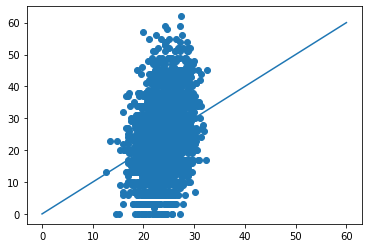

In [10]:
plt.scatter(games["x_home_score"], games["home_score"])
plt.plot([0,60], [0,60])

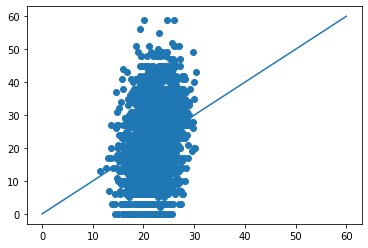

In [11]:
plt.scatter(games["x_away_score"], games["away_score"])
plt.plot([0,60], [0,60])

In [12]:

X2 = sm.add_constant(games[features])
est = sm.OLS(games["home_score"], X2)
results_new = []
results_fu = est.fit()
for x in np.arange(0.005, 0.25, 0.005).tolist():
    est2 = est.fit_regularized(L1_wt=0, alpha=x)
    results_fr_fit = sm.regression.linear_model.OLSResults(est, 
                                                            est2.params, 
                                                            results_fu.normalized_cov_params)

    results_new.append(results_fr_fit.ssr)
    # print(est2.model.score(est2.params))


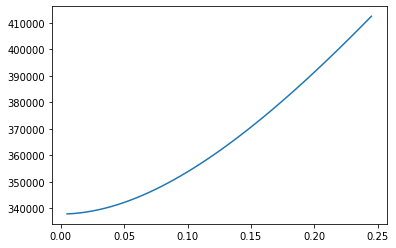

In [13]:
plt.plot(np.arange(0.005, 0.25, 0.005).tolist(), results_new)

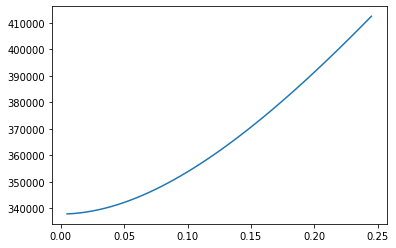

In [14]:
plt.plot(np.arange(0.005, 0.25, 0.005).tolist(), results_new)

In [15]:
results_fr = est.fit_regularized(L1_wt=0, alpha=0.1, start_params=results_fu.params)
final = sm.regression.linear_model.OLSResults(est, 
                                              results_fr.params, 
                                              est.normalized_cov_params)

print(final.summary())


                            OLS Regression Results                            
Dep. Variable:             home_score   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     26.50
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           1.14e-21
Time:                        09:49:00   Log-Likelihood:                -12766.
No. Observations:                3414   AIC:                         2.554e+04
Df Residuals:                    3409   BIC:                         2.557e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [16]:
games.to_clipboard()

In [17]:
games["total_yards_added_offense_home_per_play"] = games["total_yards_added_offense_home"] / games["play_count_offense_home"] 
games["total_yards_added_defense_home_per_play"] = games["total_yards_added_defense_home"] / games["play_count_defense_home"] 
games["total_yards_added_offense_away_per_play"] = games["total_yards_added_offense_away"] / games["play_count_offense_away"] 
games["total_yards_added_defense_away_per_play"] = games["total_yards_added_defense_away"] / games["play_count_defense_away"] 


In [18]:
games.columns

Index(['game_code', 'home_team_id', 'away_team_id', 'home_team_abbrev',
       'away_team_abbrev', 'home_score', 'away_score', 'game_date', 'season',
       'offense_team_home', 'total_expected_yards_gained_offense_home',
       'total_yards_gained_offense_home', 'total_yards_added_offense_home',
       'play_count_offense_home', 'defense_team_home',
       'total_expected_yards_gained_defense_home',
       'total_yards_gained_defense_home', 'total_yards_added_defense_home',
       'play_count_defense_home', 'offense_team_away',
       'total_expected_yards_gained_offense_away',
       'total_yards_gained_offense_away', 'total_yards_added_offense_away',
       'play_count_offense_away', 'defense_team_away',
       'total_expected_yards_gained_defense_away',
       'total_yards_gained_defense_away', 'total_yards_added_defense_away',
       'play_count_defense_away', 'x_home_score', 'x_away_score',
       'total_yards_added_offense_home_per_play',
       'total_yards_added_defense_home_p

In [19]:

new_features = [
    'total_yards_added_offense_home_per_play',
    'total_yards_added_defense_home_per_play',
    'total_yards_added_offense_away_per_play',
    'total_yards_added_defense_away_per_play',
    'play_count_offense_home',
    'play_count_defense_home',
    'play_count_offense_away', 
    'play_count_defense_away'

       ]
X2 = sm.add_constant(games[new_features])
est = sm.OLS(games["away_score"], X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:             away_score   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     38.06
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           2.16e-58
Time:                        09:49:01   Log-Likelihood:                -12565.
No. Observations:                3414   AIC:                         2.515e+04
Df Residuals:                    3405   BIC:                         2.520e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [20]:

new_features = [
    'total_yards_added_offense_home_per_play',
    'total_yards_added_defense_home_per_play',
    'total_yards_added_offense_away_per_play',
    'total_yards_added_defense_away_per_play',
    'play_count_offense_home',
    'play_count_defense_home',
    'play_count_offense_away', 
    'play_count_defense_away'

       ]
X2 = sm.add_constant(games[new_features])
est = sm.OLS(games["home_score"], X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:             home_score   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     40.38
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           5.20e-62
Time:                        09:49:02   Log-Likelihood:                -12664.
No. Observations:                3414   AIC:                         2.535e+04
Df Residuals:                    3405   BIC:                         2.540e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [21]:
X2 = sm.add_constant(games[features])
est = sm.OLS(games["away_score"], X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:             away_score   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     69.88
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           5.99e-57
Time:                        09:49:03   Log-Likelihood:                -12577.
No. Observations:                3414   AIC:                         2.516e+04
Df Residuals:                    3409   BIC:                         2.519e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [22]:
X2 = sm.add_constant(games[features])
est = sm.OLS(games["home_score"], X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:             home_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     67.98
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           1.97e-55
Time:                        09:49:03   Log-Likelihood:                -12687.
No. Observations:                3414   AIC:                         2.538e+04
Df Residuals:                    3409   BIC:                         2.542e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [23]:
games["home_team_win"] = np.where(games["home_score"] > games["away_score"], 1, 0)
games["away_team_win"] = np.where(games["home_score"] < games["away_score"], 1, 0)
games["tie"] = np.where(games["home_score"] == games["away_score"], 1, 0)

In [24]:
X2 = sm.add_constant(games[features])
est = sm.OLS(games["away_score"], X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:             away_score   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     69.88
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           5.99e-57
Time:                        09:49:03   Log-Likelihood:                -12577.
No. Observations:                3414   AIC:                         2.516e+04
Df Residuals:                    3409   BIC:                         2.519e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [25]:
import datetime as dt 

schedule = get_schedule_data(cache=cache)
schedule = schedule[schedule["game_date"].dt.date>np.max(pd.to_datetime(games["game_date"]))]


Running get_schedule_data... 

get_schedule_data is returning cached df
get_schedule_data done in 0 sec.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability copy/venv/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [26]:
np.max(pd.to_datetime(games["game_date"]))

Timestamp('2021-12-13 18:15:00')

In [27]:
X2 = sm.add_constant(games[features])
est = sm.Logit(games["tie"], X2)
est2 = est.fit()
games["x_tie"] = est2.predict(X2)

print(est2.summary())


Optimization terminated successfully.
         Current function value: 0.019513
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                    tie   No. Observations:                 3414
Model:                          Logit   Df Residuals:                     3409
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Dec 2021   Pseudo R-squ.:                 0.02487
Time:                        09:49:04   Log-Likelihood:                -66.617
converged:                       True   LL-Null:                       -68.316
Covariance Type:            nonrobust   LLR p-value:                    0.4934
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.9881      0.364    -16.432    

In [28]:
odds = pd.read_parquet("data/odds_data.parquet")
odds = odds.drop_duplicates("game_code")

In [29]:
games=games.merge(odds[["game_code", "cur_spread"]], on="game_code")

In [30]:
current_values = games_home_team.append(games_away_team).sort_values("game_date", ascending=False).drop_duplicates(["offense_team"])
current_values = current_values.merge(division_data, left_on=["season", "offense_team"], right_on=["season", "team_id"])

In [31]:
predictions = schedule.merge(current_values[['offense_team', 'total_yards_added_offense', 'total_yards_added_defense']], left_on=["home_team_id"], right_on=["offense_team"], suffixes=["", "_home"])
predictions = predictions.merge(current_values[['offense_team', 'total_yards_added_offense', 'total_yards_added_defense']], left_on=["away_team_id"], right_on=["offense_team"], suffixes=["_home", "_away"])

In [32]:
X2 = sm.add_constant(games[features])
est = sm.Logit(games["home_team_win"], X2)
est2 = est.fit()
games["x_home_team_win"] = est2.predict(X2)
predictions["x_home_team_win"] = est2.predict(sm.add_constant(predictions[features]))
print(est2.summary())


Optimization terminated successfully.
         Current function value: 0.644479
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          home_team_win   No. Observations:                 3381
Model:                          Logit   Df Residuals:                     3376
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Dec 2021   Pseudo R-squ.:                 0.06085
Time:                        09:49:07   Log-Likelihood:                -2179.0
converged:                       True   LL-Null:                       -2320.2
Covariance Type:            nonrobust   LLR p-value:                 6.866e-60
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.2622      0.036      7.237     

In [33]:
X2 = sm.add_constant(games[features])
est = sm.Logit(games["tie"], X2)
est2 = est.fit()
games["x_tie_calculated"] = est2.predict(X2)
games["x_away_team_win"] = 1 - games["x_tie_calculated"] - games["x_home_team_win"]
predictions["x_tie_calculated"] = est2.predict(sm.add_constant(predictions[features]))
predictions["x_away_team_win"] = 1 - predictions["x_tie_calculated"] - predictions["x_home_team_win"]

print(est2.summary())


Optimization terminated successfully.
         Current function value: 0.019677
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                    tie   No. Observations:                 3381
Model:                          Logit   Df Residuals:                     3376
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Dec 2021   Pseudo R-squ.:                 0.02478
Time:                        09:49:07   Log-Likelihood:                -66.528
converged:                       True   LL-Null:                       -68.219
Covariance Type:            nonrobust   LLR p-value:                    0.4962
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.9783      0.364    -16.408    

In [34]:
predictions["x_home_score"] = ridge_model_home.predict(predictions[features])
predictions["x_away_score"] = ridge_model_away.predict(predictions[features])
predictions["x_line"] = predictions["x_away_score"] - predictions["x_home_score"]

In [35]:
models = {}
for team_score in range(int(np.max(games["home_score"]+1))):
    for opponent_score in range(int(np.max(games["away_score"]+1))):
        try:
            models[str(team_score) + str(opponent_score)] = sklearn.linear_model.LogisticRegression()
            models[str(team_score) + str(opponent_score)].fit(games[features], np.where((games["home_score"]==team_score)&(games["away_score"]==opponent_score), 1, 0))
        except:
            pass


In [36]:
game_prediction_matrix = predictions[["game_code"]+features]
game_outcome_matrix = predictions[["game_code"]+features]
list_of_scores = []
list_of_home_wins = []
list_of_ties = []
list_of_away_wins = []
for team_score in range(int(np.max(games["home_score"]+1))):
    for opponent_score in range(int(np.max(games["away_score"]+1))):
        try:
            game_prediction_matrix["score_" + str(team_score) + "_" + str(opponent_score)] = pd.DataFrame(models[str(team_score) + str(opponent_score)].predict_proba(predictions[features]))[1]
            list_of_scores.append("score_" + str(team_score) + "_" + str(opponent_score))
            if team_score > opponent_score:
                list_of_home_wins.append("score_" + str(team_score) + "_" + str(opponent_score))
            elif team_score == opponent_score:
                list_of_ties.append("score_" + str(team_score) + "_" + str(opponent_score))
            else:
                list_of_away_wins.append("score_" + str(team_score) + "_" + str(opponent_score))

        except:
            game_prediction_matrix["score_" + str(team_score) + "_" + str(opponent_score)] = 0
            list_of_scores.append("score_" + str(team_score) + "_" + str(opponent_score))



/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_52104/464938458.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_prediction_matrix["score_" + str(team_score) + "_" + str(opponent_score)] = 0
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_52104/464938458.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_prediction_matrix["score_" + str(team_score) + "_" + str(opponent_score)] = 0
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_52104/464938458.py:20: SettingW

In [37]:
game_exact_score_predictions = []
for game_code in predictions["game_code"]:
    game_dict = {
        "game_code": game_code,
        "home_team_id": predictions[predictions["game_code"] == game_code][
            "home_team_id"
        ].item(),
        "away_team_id": predictions[predictions["game_code"] == game_code][
            "away_team_id"
        ].item(),
    }
    game_prediction = game_prediction_matrix[
        game_prediction_matrix["game_code"] == game_code
    ][list_of_scores].values[0]
    prob_adjustment = np.sum(game_prediction_matrix[game_prediction_matrix["game_code"]==game_code][list_of_scores].values[0])
    game_dict["pred_exact_score"] = (game_prediction / np.sum(game_prediction)).tolist()
    game_dict["pred_outcome"] = [
        np.sum(
            game_prediction_matrix[game_prediction_matrix["game_code"] == game_code][
                list_of_home_wins
            ].values[0]
        )
        / prob_adjustment,
        np.sum(
            game_prediction_matrix[game_prediction_matrix["game_code"] == game_code][
                list_of_ties
            ].values[0]
        )
        / prob_adjustment,
        np.sum(
            game_prediction_matrix[game_prediction_matrix["game_code"] == game_code][
                list_of_away_wins
            ].values[0]
        )
        / prob_adjustment,
    ]

    game_dict["current_score"] = [0, 0]
    game_exact_score_predictions.append(game_dict)


In [38]:
results_df = games.loc[games.season==2021, ["game_code", "home_team_id", "away_team_id", "home_score", "away_score"]].to_dict(orient='records')


In [39]:
team_names = games.loc[games.season==2021, ["home_team_id", "home_team_abbrev"]]
current_division_data = current_values[["offense_team", "conference_id", "division_id"]].rename(columns={'offense_team':'home_team_id'})
team_names= team_names.merge(current_division_data)
team_names = team_names.rename(columns={'home_team_id': 'id', 'home_team_abbrev': 'name'}).drop_duplicates().to_dict(orient='records')

In [40]:
# sim_data = {
#     "teams": team_names,
#     "results": results_df,
#     "predictions": game_exact_score_predictions,
#     "prediction_params": {"max_home_score": 57, "max_away_score": 59}

# }
# import json
# data_dir = "data/"
# with open(os.path.join(data_dir, 'simulation_inputs.json'), 'w') as f:
#     json.dump(sim_data, f)

In [41]:
# home_scores = []
# away_scores = []

# for team_score in range(int(np.max(games["home_score"]+1))):
#     for opponent_score in range(int(np.max(games["away_score"]+1))):
#         home_scores.append(team_score)
#         away_scores.append(opponent_score)
# score_game_example = pd.DataFrame([list_of_scores, (sim_data["predictions"][0]["pred_exact_score"]), home_scores, away_scores]).T
# score_game_example=score_game_example.rename(columns={1: "probability", 2: "home_score", 3: "away_score"})



In [42]:
# score_game_example_home = score_game_example.groupby("home_score").sum()
# score_game_example_away = score_game_example.groupby("away_score").sum()
# plt.plot(score_game_example_home["probability"])
# plt.plot(score_game_example_away["probability"])


In [43]:
pd.concat([games[["game_code", "x_home_team_win", "x_away_team_win", "game_date"]], predictions[["game_code", "x_home_team_win", "x_away_team_win", "game_date"]]]).rename(columns={"x_home_team_win": "prior_home", "x_away_team_win": "prior_away"}).to_csv("data/game_priors.csv")
os.system('say "done notebook"')


0